<font size="20"> Prediction of Heart Disease </font>

<font size="4"> Group: Christina Z, Abeer I, Adiba C, Renee C. </font>

<font size="5"> Introduction </font>




   Heart disease has been the leading cause of death in many countries (Namara et. al, 2022). High blood pressure is one of the main risk factors for heart disease among various others. With high blood pressure, the heart arteries become damaged by elasticity loss, which decreases the flow of blood to heart and leads to a heart disease (Fuchs et.al, 2020). Sex difference is also found to be a risk factor since scientists had proved that the associations between high blood pressure and heart disease were not equivalent in women and men (Colafella et.al, 2018). From this knowledge, we came up with a predictive question: what is the likelihood of developing heart disease based on blood pressure and sex? 

   We are going to use classification with K-nearest neighbors to answer our predictive question. The dataset we used contains 14 patient attributes which are relevant to the heart disease: age, sex, chest pain, resting blood pressure, …, and heart disease diagnosis. We will use sex, blood pressure and heart disease diagnosis to answer this question. 


<font size="5"> Preliminary Exploratory Data Analysis </font>

In [59]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read.csv(file = url) |>
rename(age=X63.0,
       sex=X1.0,
       chest_pain=X1.0.1,
       resting_blood_pressure=X145.0,
       cholesterol=X233.0,
       fasting_blood_sugar=X1.0.2,
       resting_electrocardiographic_results=X2.0,
       max_heart_rate=X150.0,
       exercise_induced_angina=X0.0,
       S_depression_induced=X2.3,
       slope_of_peak_exercise=X3.0,
       major_vessels=X0.0.1,
       thal=X6.0,
       heart_disease_diagnosis=X0)
heart_data 


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [56]:
#Splitting data into training and testing groups.
set.seed(20)
heart_split <- initial_split(heart_data, prop=0.75, strata=resting_blood_pressure)
    heart_train <- training(heart_split)
    heart_test <- testing(heart_split)

In [55]:
#Selected columns (sex, resting blood pressure, and heart_disease_diagnosis) from heart data.
heart_train_selected <- select(heart_train, sex, age, cholesterol, resting_blood_pressure, heart_disease_diagnosis) |>
                        arrange(sex, age, resting_blood_pressure) 
heart_train_selected

sex,age,cholesterol,resting_blood_pressure,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,35,183,138,0
0,37,215,120,0
0,39,199,94,0
⋮,⋮,⋮,⋮,⋮
1,70,245,156,0
1,70,269,160,3
1,77,304,125,4


In [57]:
#Table 1:
#Reporting the number of rows with missing data (NA's).
#Data shows that there are zero rows with missing data.
heart_train %>%
map_df(is.na) %>%
map_df(sum)

age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
#We found that the total number of rows in the heart train dataset is 224, and the number of rows after removing for
#any missing rows is also 224. This confirms that there are no rows with missing data in this dataset. 
nrow(heart_train)
nrow(heart_train %>% na.omit())

[1] 224

[1] 224

In [14]:
#Table 2:
#Reported number of observations for each class. It is found that there is the greatest amount of observations 
#found for the heart disease diagnosed as 0 and the least amount of observations for the heart disease diagnosed as 4.
count <- group_by(heart_train_selected, heart_disease_diagnosis) |>
            summarize(total=n())
count

heart_disease_diagnosis,total
<int>,<int>
0,120
1,41
2,22
3,28
4,13


In [15]:
#Table 3:
#The table below reports the average heart disease diagnosis (on a scale of 0-4) for males(1) and females(0).
#It is found that the heart disease diagnosis level is slightly greater for males (~1.03) compared to females (~0.51).
sex_vs_heart_disease <- group_by(heart_train_selected, sex) |>
                        summarize(heart_disease_diagnosis=mean(heart_disease_diagnosis, na.rm=TRUE))
sex_vs_heart_disease

sex,heart_disease_diagnosis
<dbl>,<dbl>
0,0.5882353
1,1.1602564


In [16]:
#Table 4:
#The table below reports the average resting blood pressure (mm Hg) for each heart disease diagnosis level (0-4). 
#There is generally a slight increase in resting blood pressure as the heart disease diagnosis level increases. 
heart_disease_vs_resting_blood_pressure <- group_by(heart_train_selected, heart_disease_diagnosis) |>
                                summarize(resting_blood_pressure=mean(resting_blood_pressure, na.rm=TRUE))
heart_disease_vs_resting_blood_pressure

heart_disease_diagnosis,resting_blood_pressure
<int>,<dbl>
0,128.9250
1,133.1951
2,135.7727
3,132.9286
4,138.7692


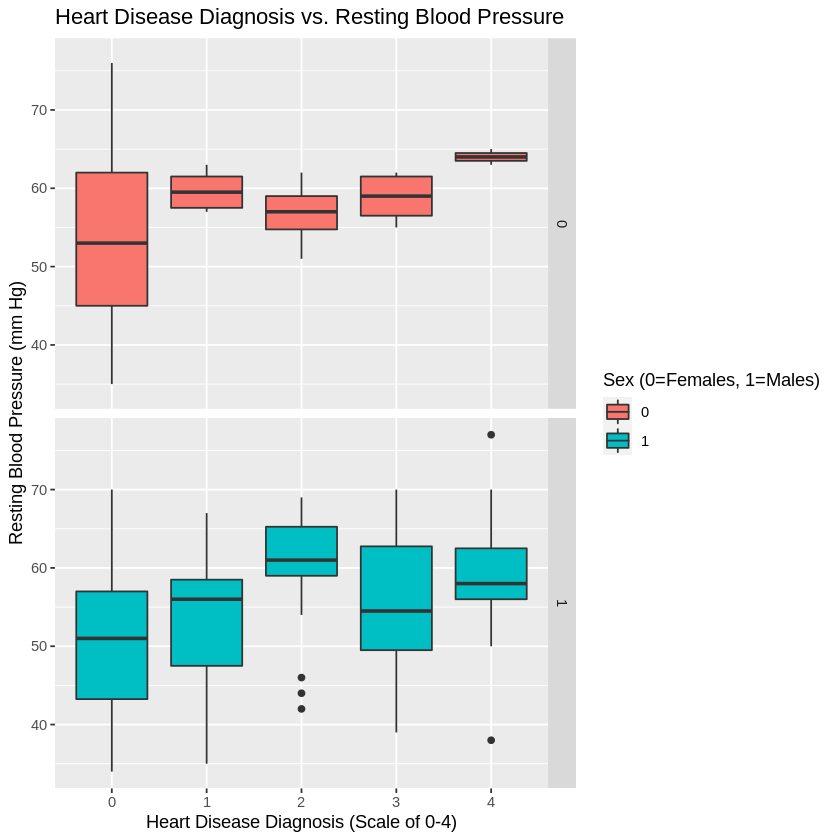

In [52]:
#Graph 1:
#Plot of heart disease diagnosis on a scale of 0-4 versus resting blood pressure (mm Hg) in men and women. 
#The graph shows that heart disease diagnosis level has a weak positive correlation with resting blood pressure for 
#both male (1) and female (0). 
#An increase in the heart disease diagnosis level correlates to a slight increase in resting blood pressure amount.
#There is a stronger relationship between heart disease diagnosis and resting blood pressure for males, but also  
#more outliers in the data. 
plot_heart_disease_vs_resting_blood_pressure <- heart_train_selected |>
                            mutate(heart_disease_diagnosis = as.factor(heart_disease_diagnosis)) |>
                            mutate(sex = as.factor(sex)) |>
                            ggplot(aes(x=heart_disease_diagnosis, y=age, fill=sex)) +
                                 geom_boxplot() +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Resting Blood Pressure (mm Hg)", fill= "Sex (0=Females, 1=Males)", title="Heart Disease Diagnosis vs. Resting Blood Pressure", )+
                            facet_grid(sex~.) 
plot_heart_disease_vs_resting_blood_pressure

In [47]:
#For our project, we are more interested in finding out whether or not heart disease is present in an individual, 
#rather than the level of heart disease severity (0, 1, 2, 3, 4). Therefore, we grouped all heart disease diagnosis
#levels of 0 into one group (represented by 0) and we grouped all heart disease diagnosis levels of 1, 2, 3, and 4, into one group
#into one group (represented by 1). The group represented by 0 indicates no heart disease present, while the group
#represented by 1 indicates the presence of heart disease. 
heart_train_grouped <- heart_train_selected |>
                        mutate(new_heart_binary=ifelse(heart_disease_diagnosis %in% c(1, 2, 3, 4), 1, 0)) |>
                        mutate(new_heart_binary = as.factor(new_heart_binary)) 

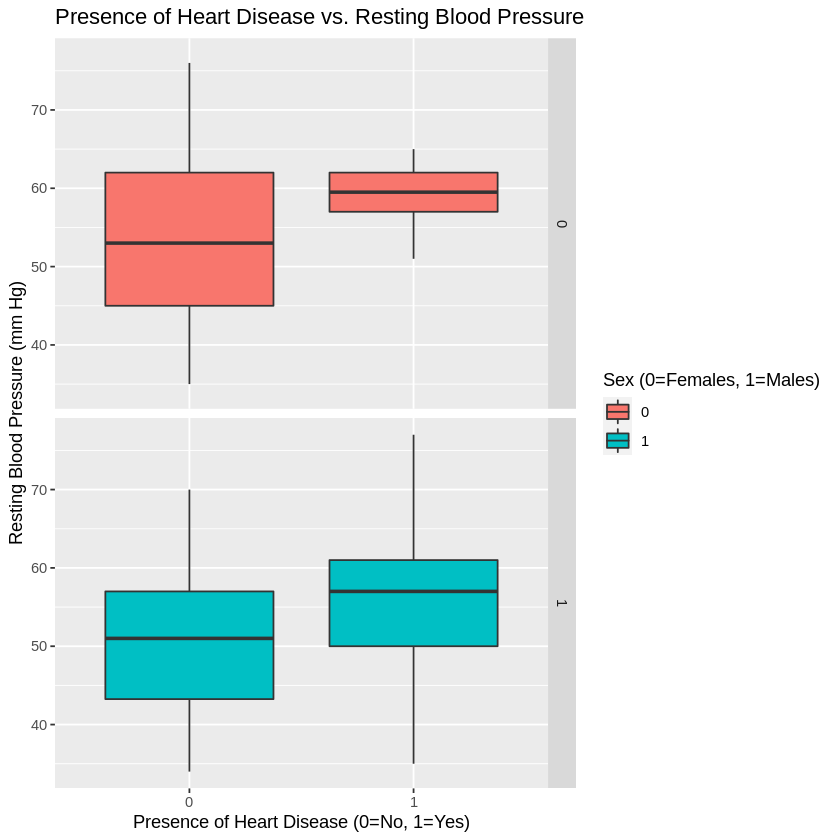

In [46]:
#Graph 2: 
#Plot of the presence of heart disease (with 0 indicating no heart disease and 1 indicating the presence of heart 
#disease) versus the resting blood pressure level (in mm Hg). From this graph, we can more easily see a correlation.
#The presence of heart disease is correlated with a higher median resting blood pressure level (~6 mm Hg increase) 
#compared to no presence of heart disease for both male (1) and female (0). Males (1) have generally a lower 
#resting blood pressure as compared to females (0). 

plot_heart_disease_vs_resting_blood_pressure <- heart_train_grouped |>
                            mutate(sex = as.factor(sex)) |>
                            ggplot(aes(x=new_heart_binary, y=age, fill=sex)) +
                                 geom_boxplot() +
                                 labs(x="Presence of Heart Disease (0=No, 1=Yes)", y="Resting Blood Pressure (mm Hg)", fill="Sex (0=Females, 1=Males)", title="Presence of Heart Disease vs. Resting Blood Pressure", )+
                            facet_grid(sex~.)
plot_heart_disease_vs_resting_blood_pressure

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5535354,5,0.025417642,Preprocessor1_Model01
1,roc_auc,binary,0.5441667,5,0.023914501,Preprocessor1_Model01
6,accuracy,binary,0.5935354,5,0.021431287,Preprocessor1_Model02
6,roc_auc,binary,0.6256151,5,0.035524108,Preprocessor1_Model02
11,accuracy,binary,0.5802020,5,0.012228482,Preprocessor1_Model03
11,roc_auc,binary,0.6356052,5,0.019555509,Preprocessor1_Model03
16,accuracy,binary,0.6120202,5,0.025661536,Preprocessor1_Model04
16,roc_auc,binary,0.6386409,5,0.021191937,Preprocessor1_Model04
21,accuracy,binary,0.5623232,5,0.014672217,Preprocessor1_Model05


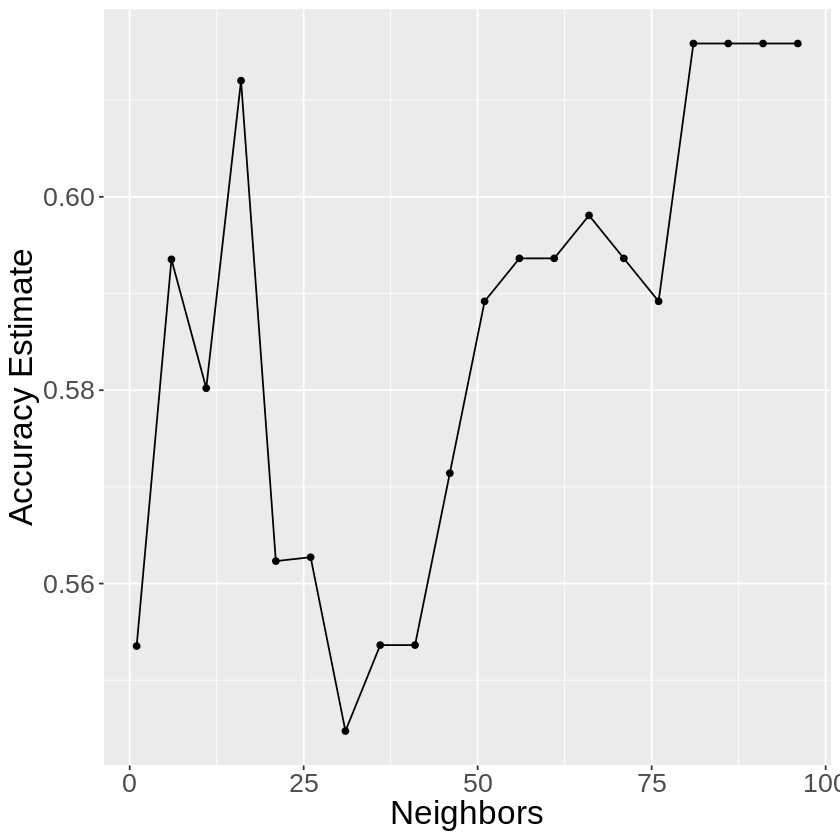

In [53]:
set.seed(20)
#set seed to ensure we are using the same randomised numbers

heart_vfold <- vfold_cv(heart_train_grouped, v = 5, strata = new_heart_binary)

heart_recipe <- recipe(new_heart_binary ~ resting_blood_pressure + sex, data = heart_train_grouped) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors=seq(from=1, to=100, by=5))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()
knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot


<font size="5"> Methods </font>

We will create a summary table to predict whether heart disease diagnosis is affected by the factors. The original data set is quite tidy but not all the data is relevant. Therefore we use select() to create a table with relevant data(blood pressure, sex and heart disease diagnosis). Next, we will create a visualisation plot. We will make a box-plot and use facet_grid() to create visualisation plots that show how the factors interact for each gender on top of each other. 

To create the model we will split our dataset into training and testing dataset, setting aside the test dataset until the end to test our model. The training dataset will be further broken up into validation and training set 5 times (5-fold cross validation). Then, we will create a plot of accuracy versus k value to ensure we pick the k-value with the highest accuracy to ensure our model is as accurate as possible. We will use k-nearest-neighbour and use the two factors as the predictors and predict whether heart disease is present or not.


<font size="5"> Expected outcomes and significance </font>

Colafella et.al had claimed that the associations between high blood pressure and heart disease outcomes were not equivalent in women and men. However, a clear relationship with sufficient data was not presented. Thus, we expect to find a relationship between blood pressure, sex and heart disease in order to better predict the chance of getting heart disease. 
  
These findings could be impactful in providing more of a visual and explanatory answer to the relationship between sex with blood pressure & heart disease diagnoses; a strong relationship would allow a more accurate model that can help people predict their chance of getting heart disease. As well, if the findings supplement Colafella et.al’s claim, more research can be conducted to understand the causes for the difference. 
        
Furthermore, it could lead to the question of helping people to get their results to the optimal healthy level, which will help lower their chances of getting CHD or at least subvert some of the symptoms to a more manageable level. That way, more people can create a health plan that helps themselves in terms of their health.


<font size="5"> References </font>

Fuchs, F. D. & Whelton, P. K.(2020). High blood pressure and cardiovascular disease. Hypertension 75(2). 285–292.doi.org/10.1161/HYPERTENSIONAHA.119.14240.

Namara, K., Alzubaidi, H., Jackson, JK. (2019). Cardiovascular disease as a leading cause of death: how are pharmacists getting involved?. Integr Pham Res Pract. 8.1-11. doi: 10.2147/IPRP.S133088. 

Colafella, KMM., Denton, KM. (2017). Sex-specific differences in hypertension and associated cardiovascular disease. Nat Rev Nephrol. 14. 185-201.  doi: 10.1038/nrneph.2017.189.